In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.metrics import r2_score

# Load and prepare the data

In [2]:
# Load the CSV files
training_data_path = 'MethaneFlameletData_LUT.csv'
validation_data_path = 'MethaneFlameletData_Validation.csv'

training_data = pd.read_csv(training_data_path)
validation_data = pd.read_csv(validation_data_path)

In [3]:
# Define query and output variables
query_vars = ['ProgressVariable', 'EnthalpyTot', 'MixtureFraction']
output_vars = ['Temperature', 'MolarWeightMix', 'DiffusionCoefficient', 'Conductivity', 'ViscosityDyn']


In [4]:
training_data.head()

,ProgressVariable,EnthalpyTot,MixtureFraction,Temperature,MolarWeightMix,DiffusionCoefficient,Conductivity,ViscosityDyn,Cp,Beta_ProgVar,Beta_Enth_Thermal,Beta_Enth,Beta_MixFrac,ProdRateTot_PV,Heat_Release
0,0.275328,-348296.924566,0.055187,2265.234521,27.633487,0.000692,0.156198,0.000072,1519.112783,0.268027,1245.950348,-2.700807e+06,0.008485,0.000000e+00,0.000000e+00
1,-0.275321,-276088.846448,0.055247,280.007796,27.626493,0.000020,0.025614,0.000017,1073.223825,-0.256329,1030.225655,-2.683107e+05,0.007472,1.026737e-09,4.907443e-03
2,-0.076155,-744939.200035,0.056153,745.767026,27.087835,0.000112,0.061628,0.000034,1247.764023,-0.061983,1075.123604,-1.245667e+06,0.011333,1.930628e+00,1.364587e+07
3,0.197244,-551763.696470,0.054517,1795.653733,27.021471,0.000500,0.134138,0.000061,1463.679971,0.190669,1200.449935,-2.062156e+06,0.012733,1.025944e+02,2.376112e+08
4,-0.275288,-237762.197366,0.055385,315.689905,27.610341,0.000025,0.028406,0.000019,1081.937567,-0.255961,1031.581149,-2.670067e+05,0.008084,3.096956e-07,1.557528e+00


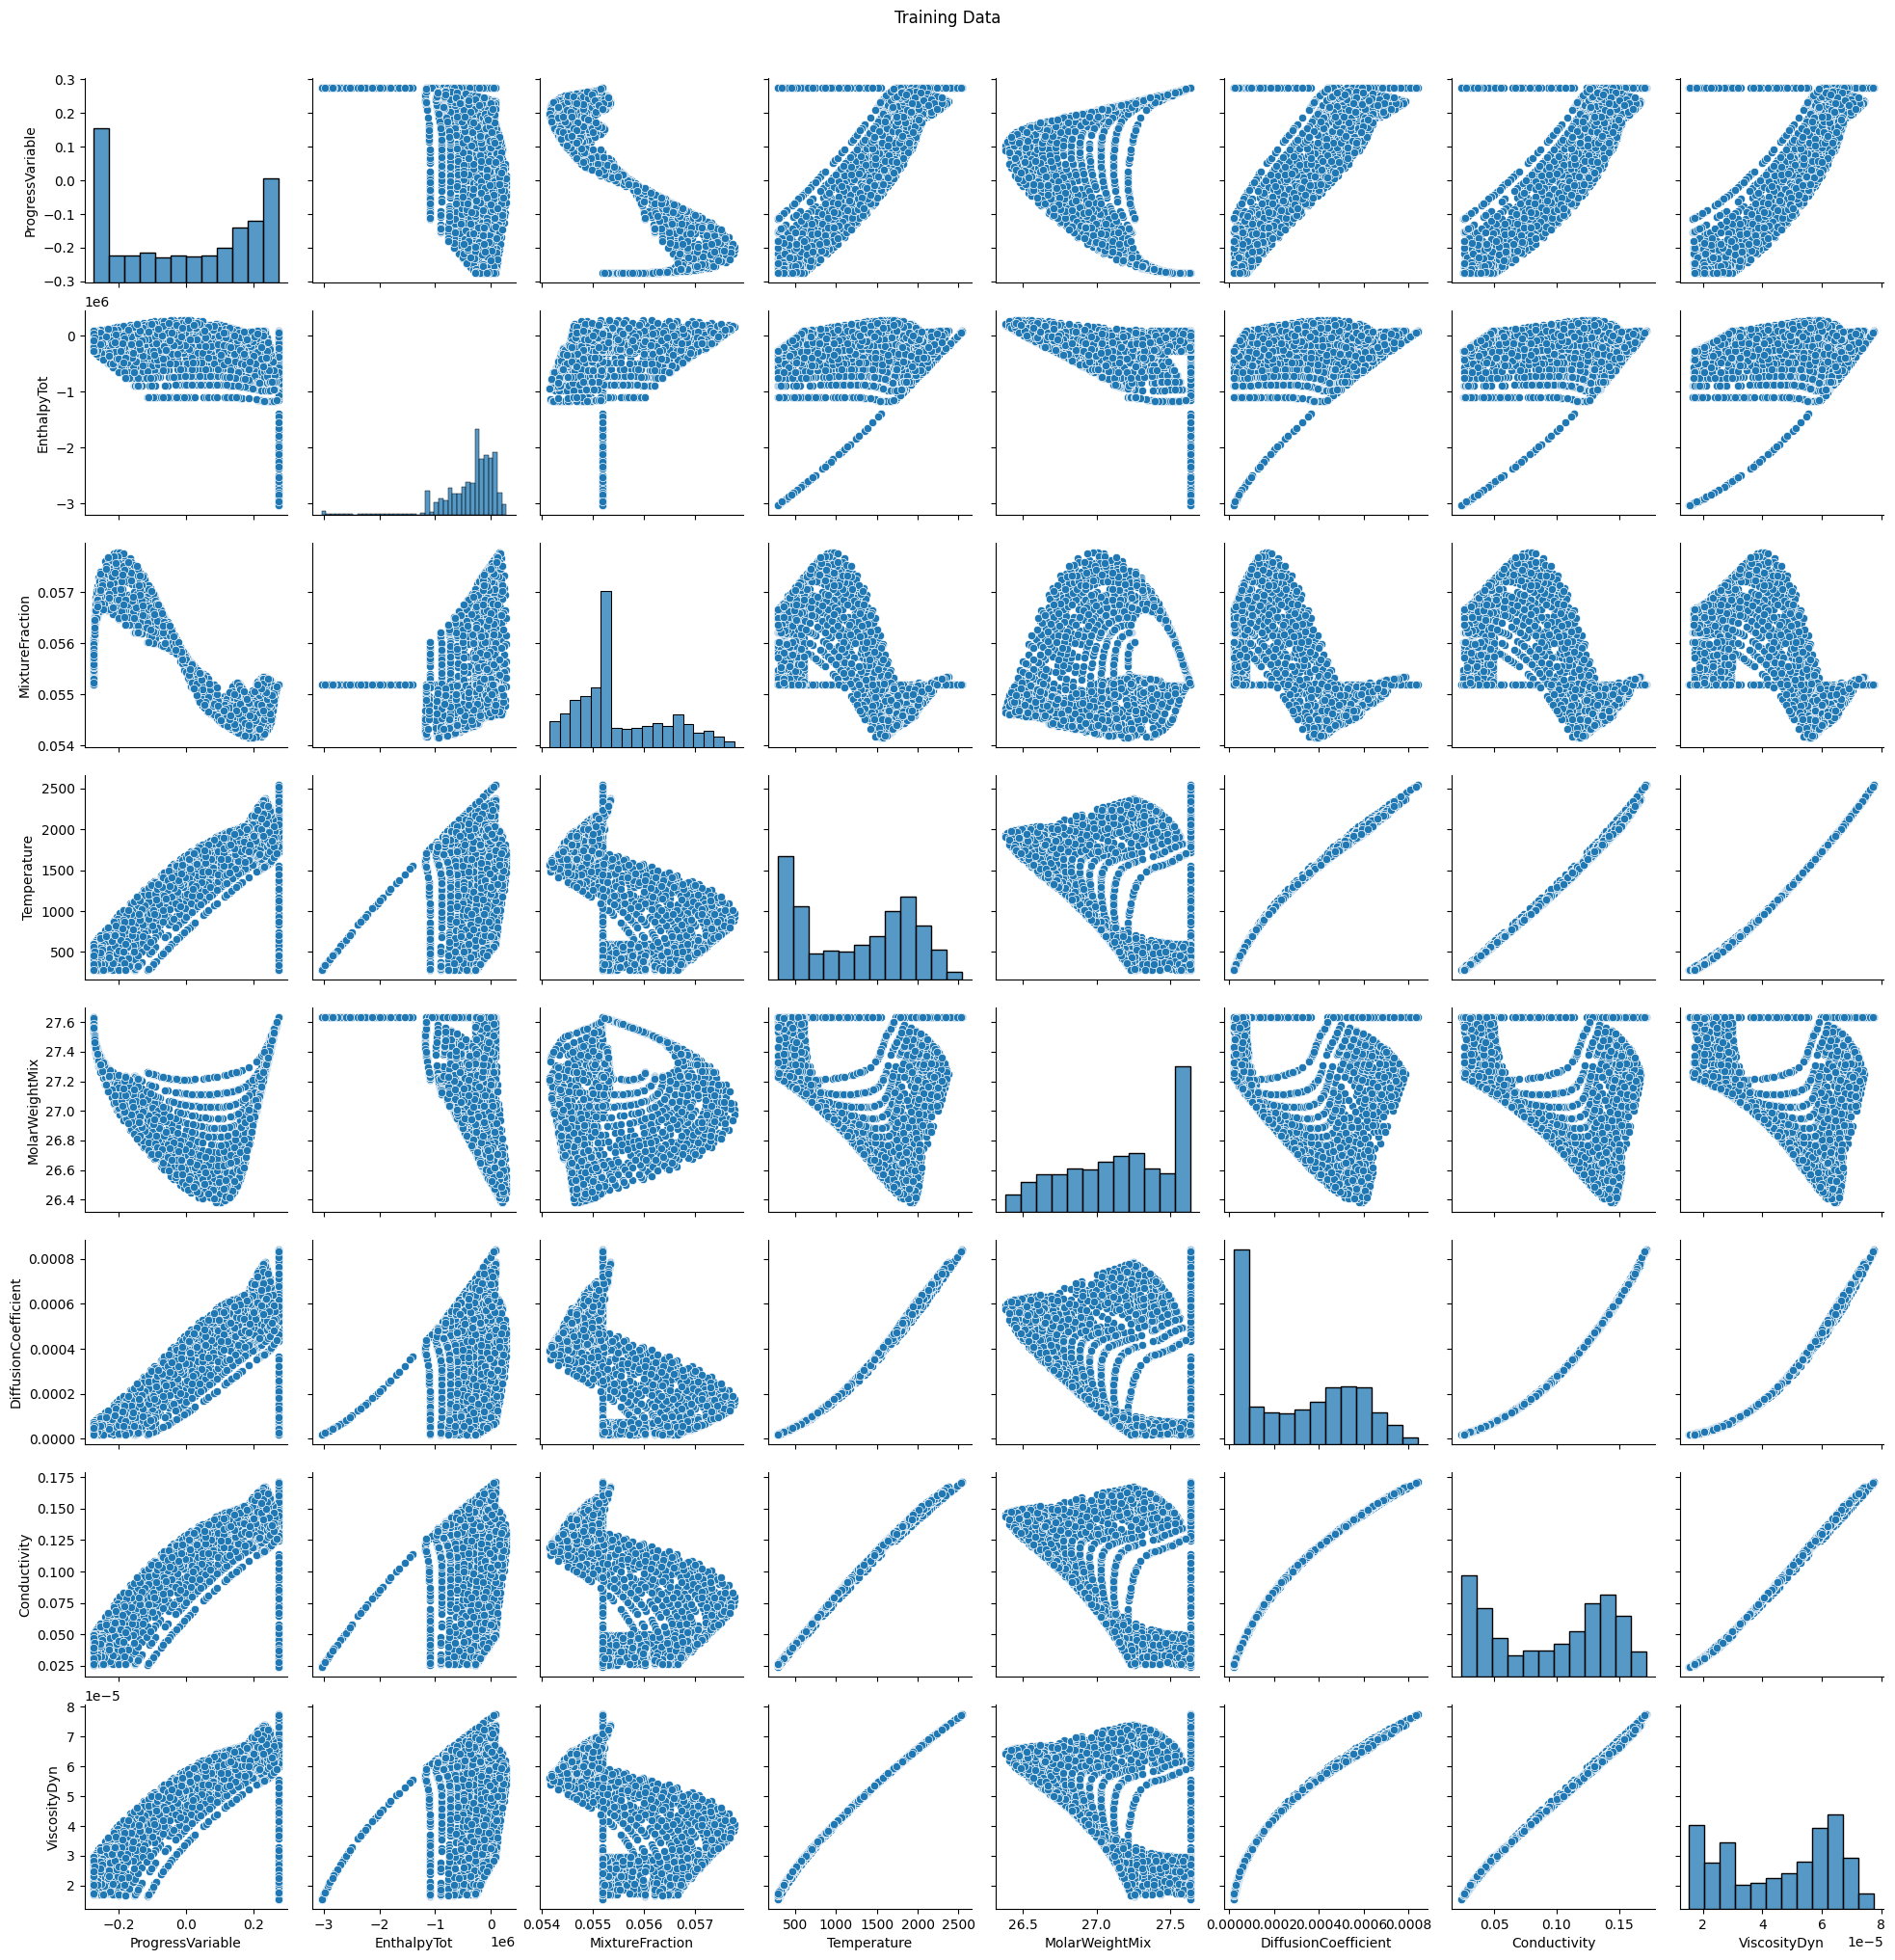

In [5]:
# Visualize training data
sns.pairplot(training_data[query_vars + output_vars])
plt.suptitle('Training Data', y=1.02)
plt.show()

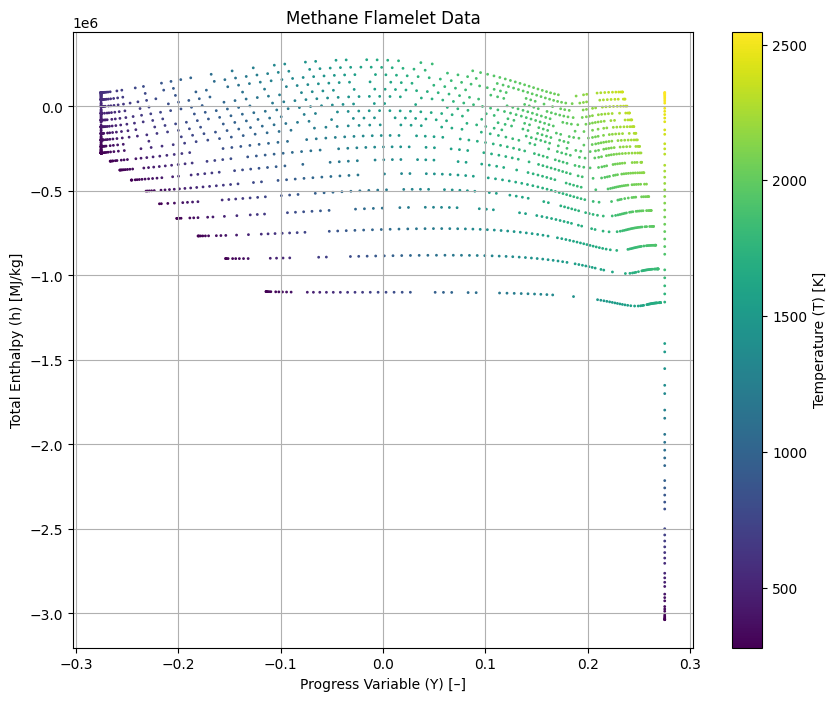

In [6]:
# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(training_data['ProgressVariable'], training_data['EnthalpyTot'], 
                      c=training_data['Temperature'], cmap='viridis', s=1)
plt.colorbar(scatter, label='Temperature (T) [K]')
plt.xlabel('Progress Variable (Y) [–]')
plt.ylabel('Total Enthalpy (h) [MJ/kg]')
plt.title('Methane Flamelet Data')
plt.grid(True)
plt.show()

In [7]:
validation_data.head()

,ProgressVariable,EnthalpyTot,MixtureFraction,Temperature,MolarWeightMix,DiffusionCoefficient,Conductivity,ViscosityDyn,Cp,Beta_ProgVar,Beta_Enth_Thermal,Beta_Enth,Beta_MixFrac,ProdRateTot_PV,Heat_Release
0,0.237374,-8.484003e+05,0.054455,1766.208883,27.362582,0.000475,0.131207,0.000061,1462.123065,0.225879,1211.463201,-2.419794e+06,0.010493,6.148721,4.196702e+07
1,0.170692,-1.233319e+05,0.055003,1944.587002,26.688601,0.000585,0.145015,0.000065,1482.394628,0.166746,1193.753940,-1.661934e+06,0.015932,210.323913,4.130330e+08
2,-0.273938,-4.069268e+04,0.056139,500.082747,27.514195,0.000055,0.042429,0.000026,1145.001750,-0.253333,1041.158137,-2.609244e+05,0.010981,0.004407,2.237718e+04
3,0.275328,-2.943352e+06,0.055187,363.917552,27.633487,0.000029,0.030062,0.000019,1127.200353,0.257675,1018.959782,-2.952100e+06,0.006933,0.000000,0.000000e+00
4,-0.275328,-2.760898e+05,0.055187,279.999282,27.633488,0.000020,0.025595,0.000017,1072.959835,-0.256471,1030.855815,-2.684343e+05,0.007267,-0.000029,-4.958313e+01


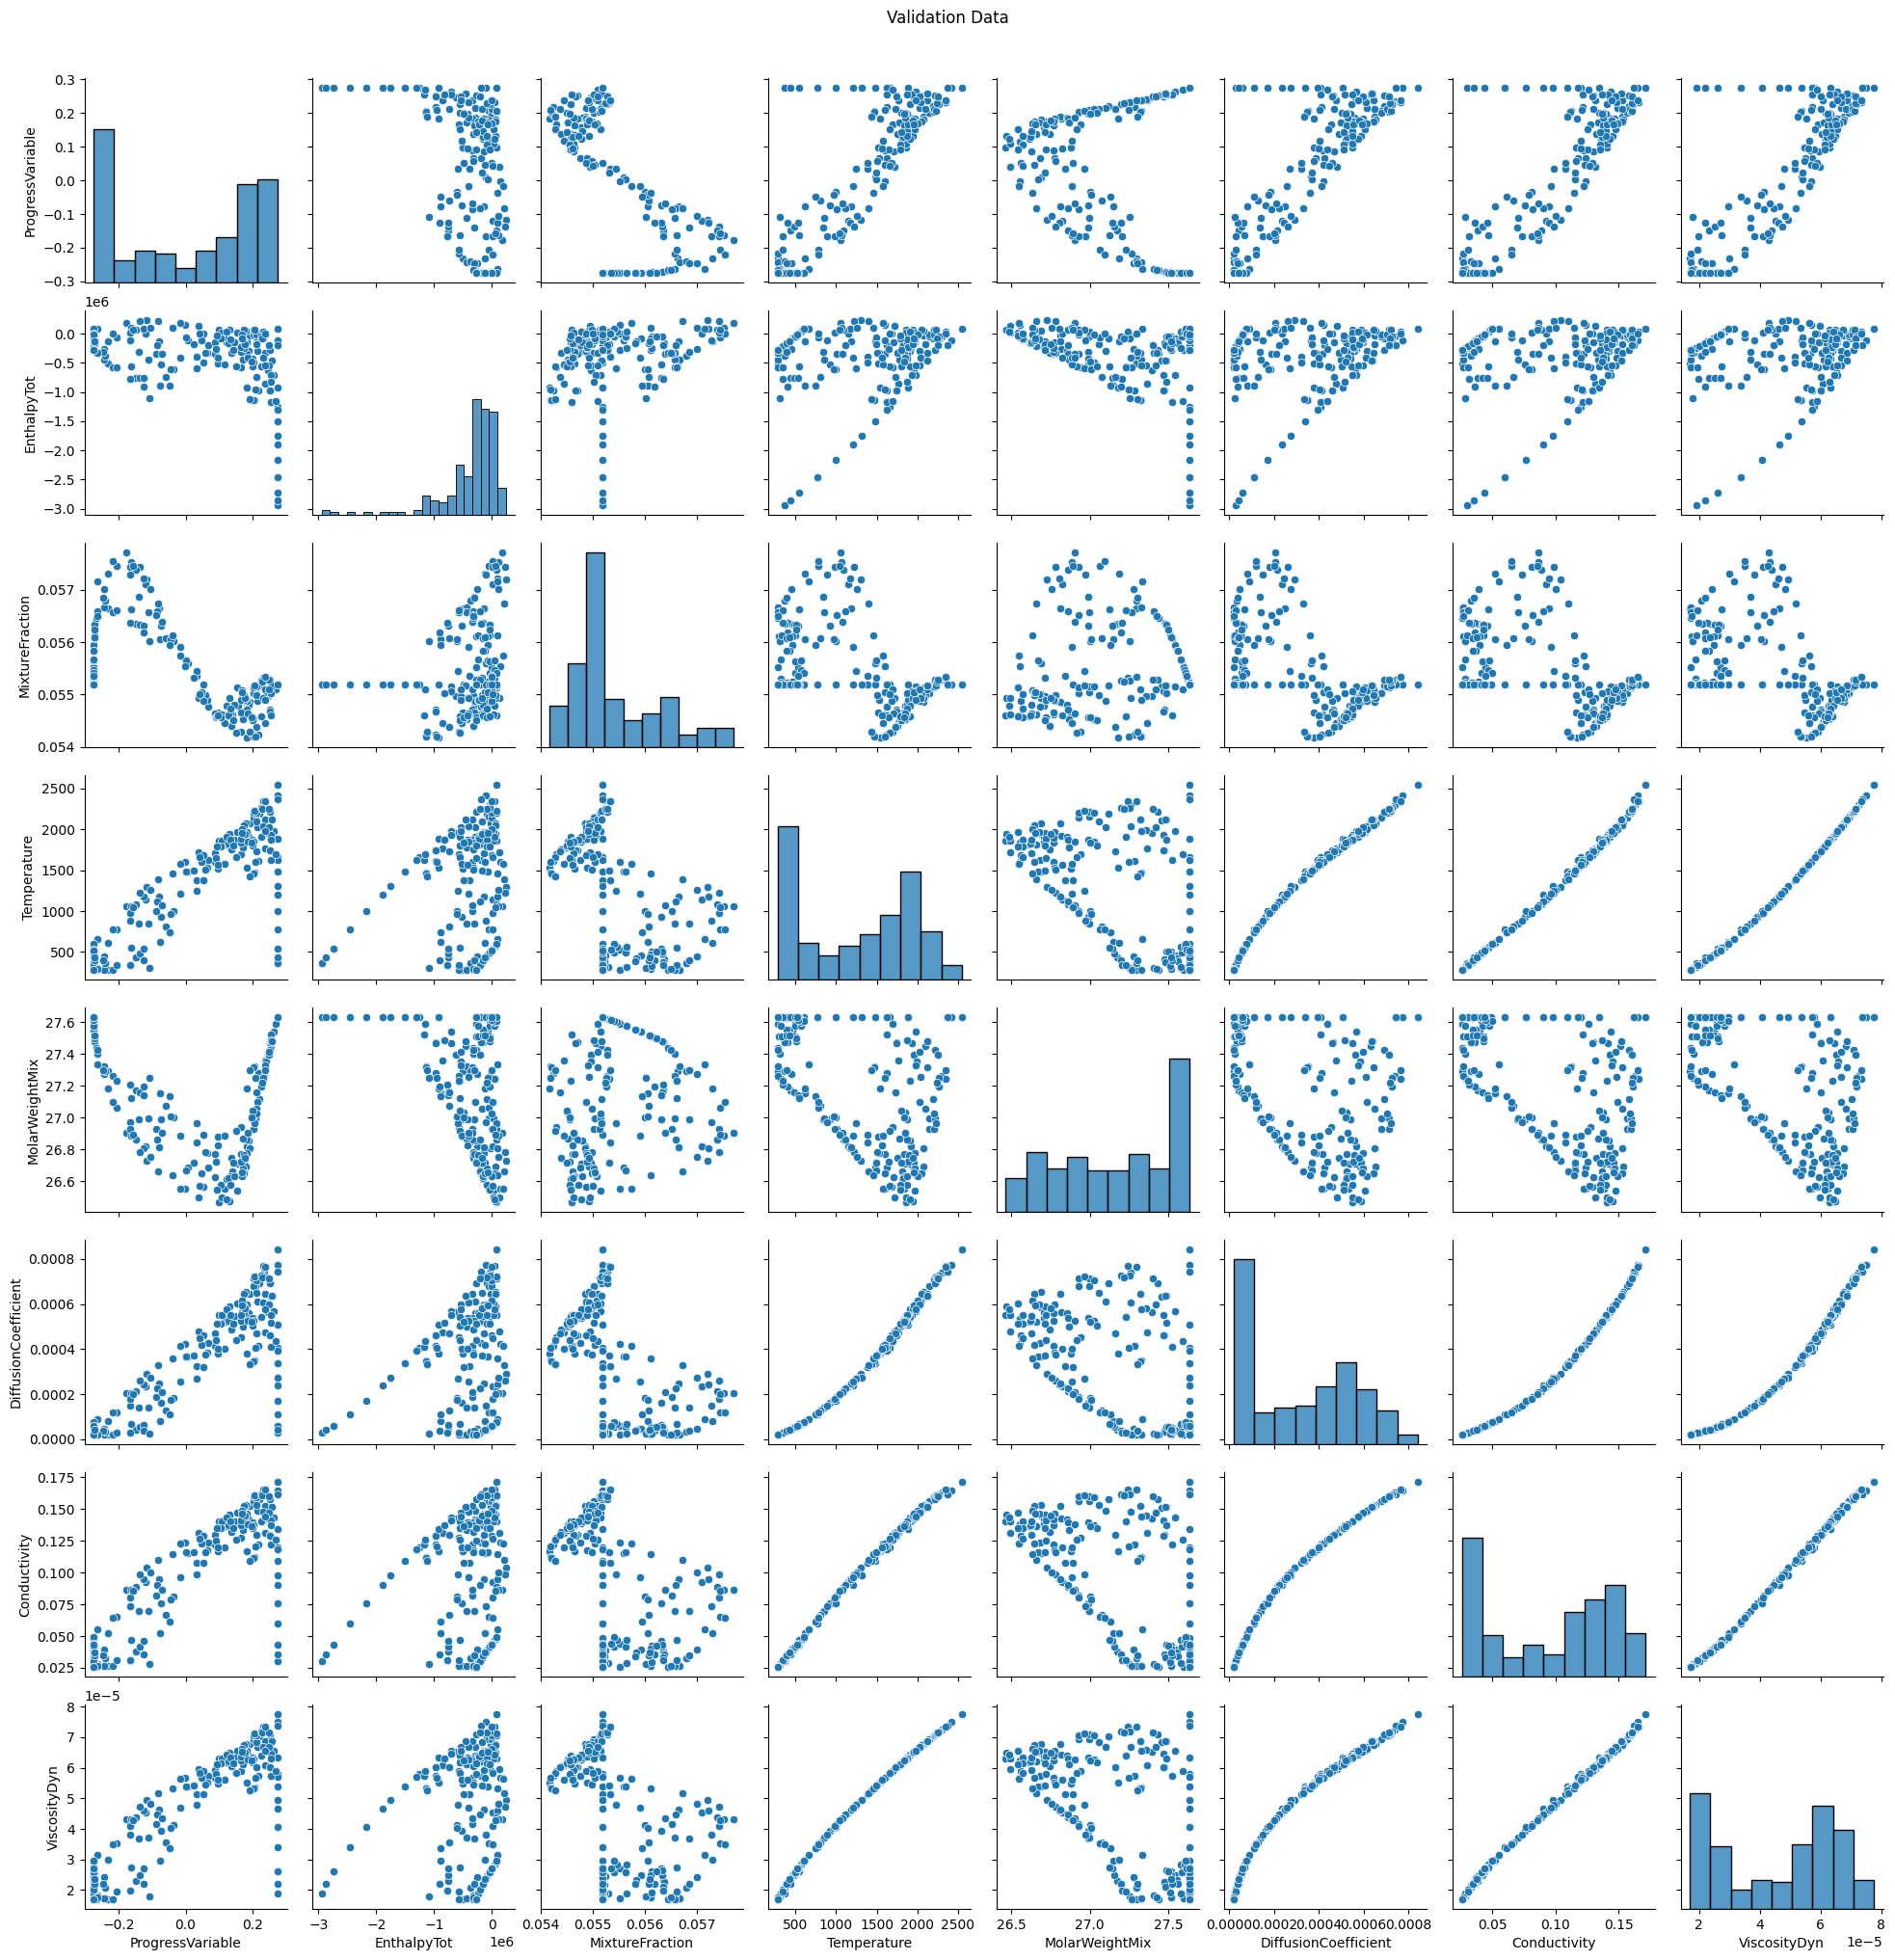

In [8]:
# Visualize validation data
sns.pairplot(validation_data[query_vars + output_vars])
plt.suptitle('Validation Data', y=1.02)
plt.show()

In [9]:
# Extract query variables and output variables from training data
train_queries = training_data[query_vars].values
train_outputs = training_data[output_vars].values


In [10]:
# Extract query variables from validation data
validation_queries = validation_data[query_vars].values


In [12]:
quantile_transformer = QuantileTransformer(output_distribution='uniform')
train_queries_scaled = quantile_transformer.fit_transform(train_queries)
validation_queries_scaled = quantile_transformer.transform(validation_queries)


# Create a KDTree from the training data.


In [13]:
# Create a KDTree from the training data
kdtree = KDTree(train_queries_scaled)

# Query the KDTree for the nearest neighbors.



In [14]:
# Define a function to interpolate using KDTree
def kdtree_interpolate(query_points, kdtree, data_points, values, k=3):
    interpolated_values = []
    for point in query_points:
        distances, indices = kdtree.query(point, k=k)
        weights = 1 / distances
        weights /= np.sum(weights)
        interpolated_value = np.dot(weights, values[indices])
        interpolated_values.append(interpolated_value)
    return np.array(interpolated_values)

# Interpolate using the nearest neighbors.

In [15]:
# Apply the KDTree-based interpolator to the validation data
k = 3
kdtree_interpolated_values = kdtree_interpolate(validation_queries_scaled, kdtree, train_queries, train_outputs, k=k)


In [16]:
# Convert the results to a DataFrame
kdtree_interpolated_df = pd.DataFrame(kdtree_interpolated_values, columns=output_vars)
print(kdtree_interpolated_df.head())

   Temperature  MolarWeightMix  DiffusionCoefficient  Conductivity  \
0  1770.920406       27.366343              0.000477      0.131472   
1  1924.261269       26.673734              0.000575      0.143666   
2   503.284133       27.530028              0.000056      0.042608   
3   369.947050       27.633487              0.000030      0.030506   
4   279.999271       27.633488              0.000020      0.025595   

   ViscosityDyn  
0      0.000061  
1      0.000064  
2      0.000026  
3      0.000019  
4      0.000017  


In [17]:
validation_data[output_vars].head()

,Temperature,MolarWeightMix,DiffusionCoefficient,Conductivity,ViscosityDyn
0,1766.208883,27.362582,0.000475,0.131207,0.000061
1,1944.587002,26.688601,0.000585,0.145015,0.000065
2,500.082747,27.514195,0.000055,0.042429,0.000026
3,363.917552,27.633487,0.000029,0.030062,0.000019
4,279.999282,27.633488,0.000020,0.025595,0.000017


# Error Analysis.

In [18]:
# Extract actual output variables from validation data
validation_outputs = validation_data[output_vars].values

# Function to calculate error metrics
def calculate_error_metrics(predicted, actual):
    mae = np.mean(np.abs(predicted - actual), axis=0)
    rmse = np.sqrt(np.mean((predicted - actual) ** 2, axis=0))
    mape = np.mean(np.abs((predicted - actual) / actual) * 100, axis=0)
    return mae, rmse, mape

# Calculate error metrics
mae, rmse, mape = calculate_error_metrics(kdtree_interpolated_values, validation_outputs)

# Create a DataFrame to display the results
error_metrics_df = pd.DataFrame({
    'MAE': mae,
    'RMSE': rmse,
    'MAPE': mape
}, index=output_vars)

print(error_metrics_df)

                               MAE          RMSE      MAPE
Temperature           1.181298e+01  2.024877e+01  1.087791
MolarWeightMix        9.604688e-03  2.003195e-02  0.035631
DiffusionCoefficient  4.524953e-06  8.329485e-06  1.855356
Conductivity          7.745428e-04  1.287402e-03  0.940346
ViscosityDyn          3.124285e-07  5.131879e-07  0.759646


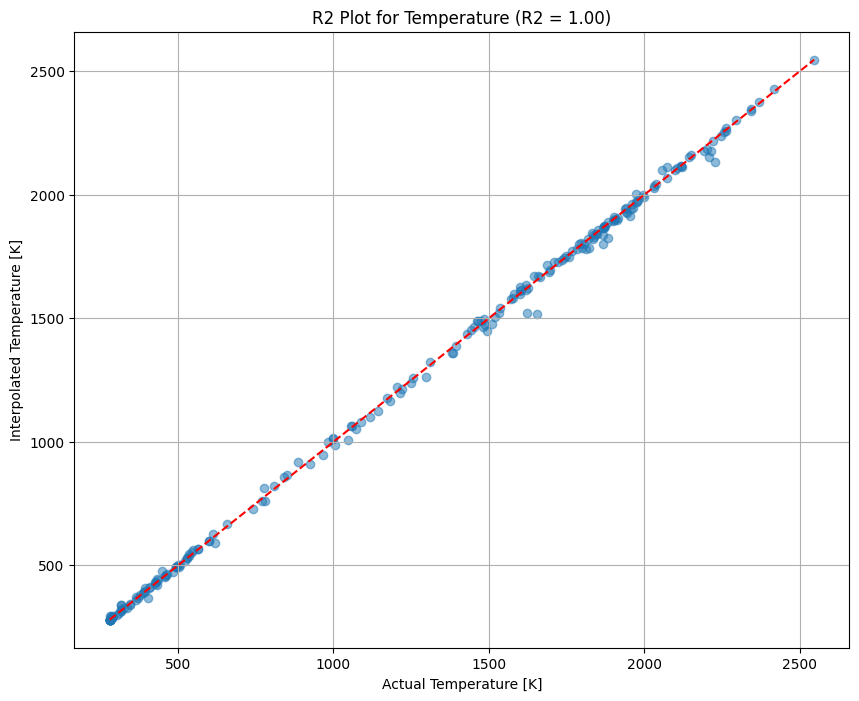

R2 Scores for all output variables:
Temperature: 1.00
MolarWeightMix: 1.00
DiffusionCoefficient: 1.00
Conductivity: 1.00
ViscosityDyn: 1.00


In [19]:
# Calculate R-squared for each output variable
r2_scores = {}
for i, var in enumerate(output_vars):
    r2_scores[var] = r2_score(validation_outputs[:, i], kdtree_interpolated_values[:, i])

# Plotting the R2 plots for Temperature
plt.figure(figsize=(10, 8))
plt.scatter(validation_outputs[:, 0], kdtree_interpolated_values[:, 0], alpha=0.5)
plt.plot([min(validation_outputs[:, 0]), max(validation_outputs[:, 0])], 
         [min(validation_outputs[:, 0]), max(validation_outputs[:, 0])], 'r--')
plt.xlabel('Actual Temperature [K]')
plt.ylabel('Interpolated Temperature [K]')
plt.title(f'R2 Plot for Temperature (R2 = {r2_scores["Temperature"]:.2f})')
plt.grid(True)
plt.show()

# Display R2 scores for all output variables
print("R2 Scores for all output variables:")
for var, score in r2_scores.items():
    print(f"{var}: {score:.2f}")

# Visualize the data.

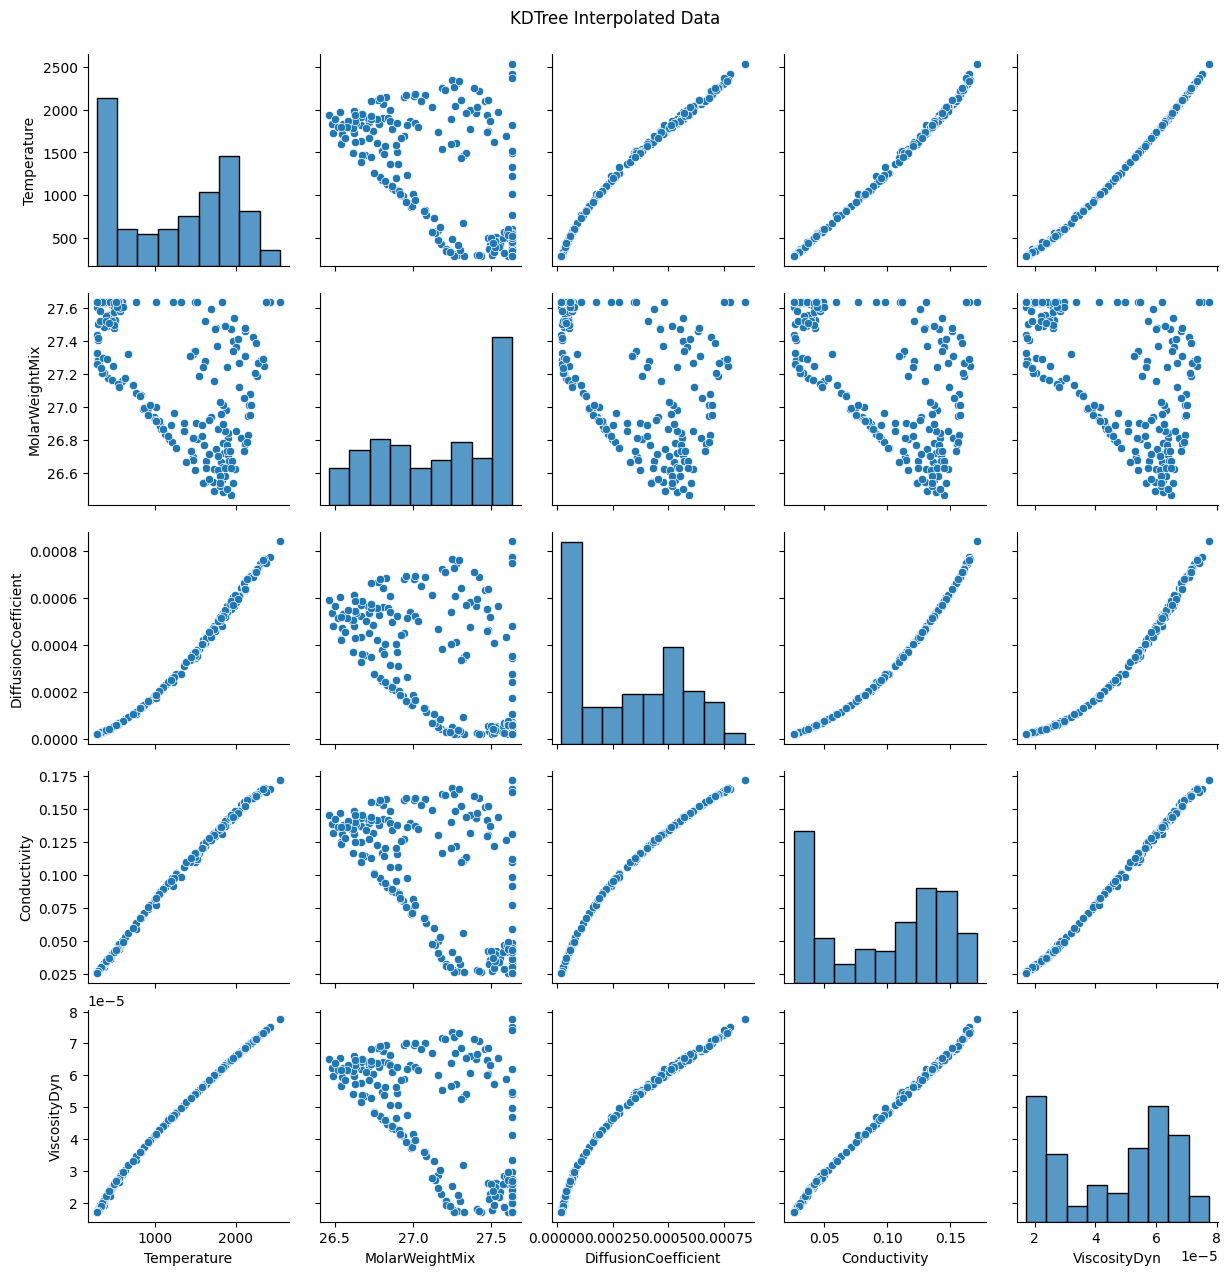

In [20]:
# Visualize interpolated results
sns.pairplot(kdtree_interpolated_df)
plt.suptitle('KDTree Interpolated Data', y=1.02)
plt.show()

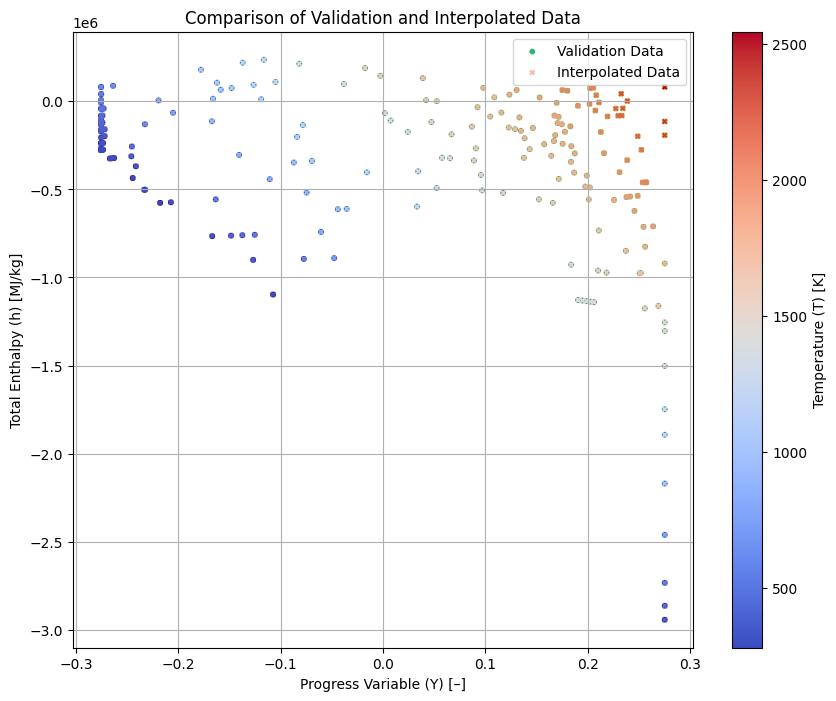

In [21]:
# Plotting
plt.figure(figsize=(10, 8))

# Actual Validation Data
plt.scatter(validation_data['ProgressVariable'], validation_data['EnthalpyTot'], 
            c=validation_data['Temperature'], cmap='viridis', s=10, label='Validation Data')

# Interpolated Data
plt.scatter(validation_data['ProgressVariable'], validation_data['EnthalpyTot'], 
            c=kdtree_interpolated_df['Temperature'], cmap='coolwarm', s=10, marker='x', label='Interpolated Data')

plt.colorbar(label='Temperature (T) [K]')
plt.xlabel('Progress Variable (Y) [–]')
plt.ylabel('Total Enthalpy (h) [MJ/kg]')
plt.title('Comparison of Validation and Interpolated Data')
plt.legend()
plt.grid(True)
plt.show()